In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [2]:
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u4.base'),Path('/root/.fastai/data/ml-100k/u4.test'),Path('/root/.fastai/data/ml-100k/u.data'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/mku.sh'),Path('/root/.fastai/data/ml-100k/ua.test'),Path('/root/.fastai/data/ml-100k/ua.base'),Path('/root/.fastai/data/ml-100k/u.item'),Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/u3.test')...]

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t',header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies= pd.read_csv(path/'u.item',  delimiter='|',encoding='latin-1',
                    usecols=(0,1),names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [6]:
ratings.rating.unique()

array([3, 1, 2, 4, 5])

Cross entropy loss:
$$ H(y, \hat{y}) = \sum_i y_i \log \frac{1}{\hat{y}_i} = -\sum_i y_i \log \hat{y}_i $$

But the rating have 1 to 5 indexing like this will fail as tesnor 0<sup>th</sup>. 

In [7]:
ratings.rating = ratings.rating -1
ratings.rating.unique()

array([2, 0, 1, 3, 4])

In [8]:
dls = CollabDataLoaders.from_df(ratings, user_name='user', item_name='title', rating_name='rating', bs=64)
dls.show_batch()

,user,title,rating
0,270,Once Upon a Time... When We Were Colored (1995),4
1,639,"Adventures of Priscilla, Queen of the Desert, The (1994)",1
2,535,Psycho (1960),3
3,634,Rosewood (1997),2
4,901,Escape from New York (1981),1
5,22,In the Line of Fire (1993),2
6,798,Emma (1996),4
7,84,Broken Arrow (1996),2
8,307,"Nightmare Before Christmas, The (1993)",3
9,426,Gigi (1958),3


In [9]:
class CollabNNCEL(Module):
    def __init__(self, user_sz, movie_sz, n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.movie_factors = Embedding(*movie_sz)

        self.layers = nn.Sequential(
            nn.Linear(user_sz[1] + movie_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 5),
            nn.Softmax(dim=1),
        )

    
    def forward(self, x):
        embds = self.user_factors(x[:,0]), self.movie_factors(x[:,1])

        x = self.layers(torch.cat(embds, dim=1))
        return x

In [10]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [11]:
model = CollabNNCEL(*embs)

In [12]:
X, Y = dls.one_batch()
X.shape, Y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

In [13]:
y_pred = model.forward(X)
y_pred.shape, y_pred[0].sum()

(torch.Size([64, 5]), tensor(1.0000, grad_fn=<SumBackward0>))

In [14]:
Y.shape, Y.squeeze().shape, Y.shape[0]

(torch.Size([64, 1]), torch.Size([64]), 64)

In [15]:
arr = [i for i in range(64)]
y_pred[arr,Y.squeeze().long()].shape, y_pred[arr,Y.squeeze().long()].mean()

(torch.Size([64]), tensor(0.1981, grad_fn=<MeanBackward0>))

In [16]:
def loss_func(pred, target):
    arr = [i for i in range(target.shape[0])]
    return pred[arr,target.squeeze().long()].mean()

In [17]:
loss_func(y_pred, Y)

tensor(0.1981, grad_fn=<MeanBackward0>)

In [20]:
learn_CE = Learner(dls, model, loss_func=loss_func)
learn_CE.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.034418,0.036606,00:28
1,0.027384,0.036482,00:24
2,0.030381,0.036014,00:24
3,0.025519,0.034647,00:24
4,0.024449,0.034510,00:25


In [21]:
movie_embedding = model.movie_factors
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)'] #extract the index of the movie
idx

1330

In [22]:
movie_embedding

Embedding(1665, 102)

In [23]:
movie_embedding.weight[idx].shape

torch.Size([102])

In [24]:
mov_embd = movie_embedding.weight[idx][None]
idx, mov_embd.shape

(1330, torch.Size([1, 102]))

In [25]:
cos = nn.CosineSimilarity(dim=1)
dist = cos(movie_embedding.weight, mov_embd)

In [26]:
dist[idx]

tensor(1.0000, grad_fn=<SelectBackward0>)

In [27]:
dls.classes['title'][dist.argsort(descending=True)[:10]]

(#10) ['Silence of the Lambs, The (1991)','Unforgiven (1992)','Pulp Fiction (1994)','Gattaca (1997)','Jerry Maguire (1996)','Dazed and Confused (1993)','Full Monty, The (1997)','Blues Brothers, The (1980)','Evil Dead II (1987)','Godfather: Part II, The (1974)']

In [28]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn_CE.dls.classes['title'].o2i[m] for m in top_movies])

In [29]:
movie_w = learn_CE.model.movie_factors.weight[top_idxs].cpu().detach()

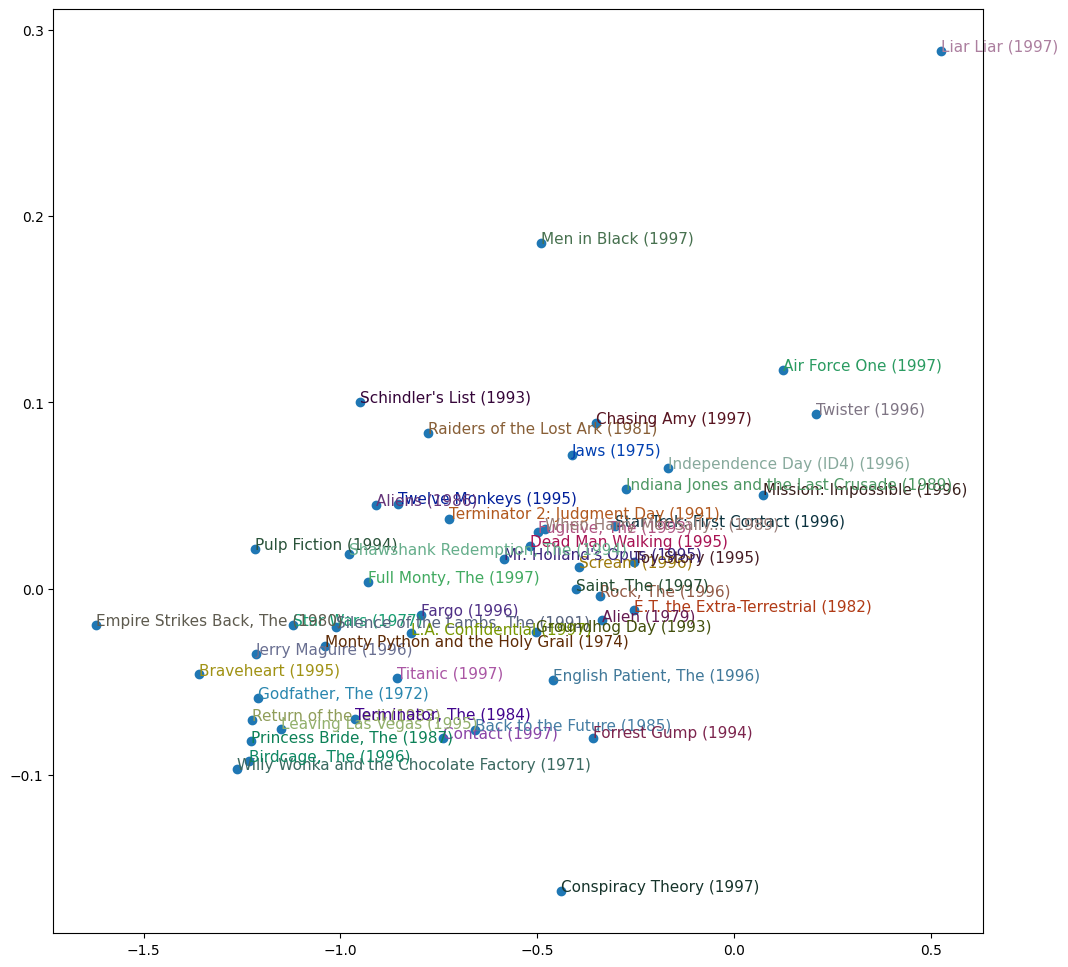

In [30]:
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()